#### Segmentación de pacientes (Clustering)
- Objetivo: descubrir subgrupos naturales (sin target predefinido).

In [50]:
# Importar librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import pickle

from sklearn.pipeline import Pipeline


In [51]:
# Carga de datos 
df = pd.read_csv('../data/combined_sleep_dataset.csv')
num_df = df.select_dtypes(include=['int64','float64']).drop(columns=['Sleep_disorder','Diagnosis_Confirmed'])

In [52]:
# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

In [53]:
# Reducción a 2 componentes para visualización
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

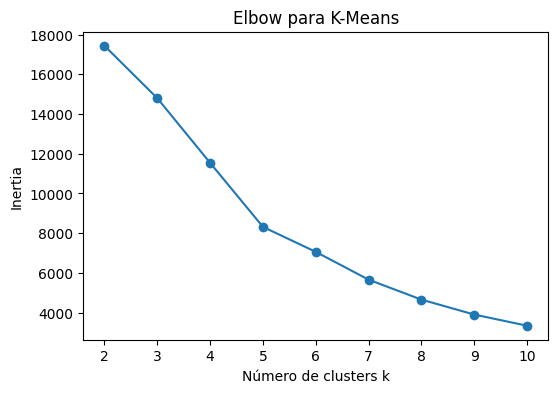

In [54]:
# Elbow method para K-Means
inertia = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'o-')
plt.xlabel('Número de clusters k')
plt.ylabel('Inertia')
plt.title('Elbow para K-Means')
plt.show()


- El "codo" está en k = 4, lo que sugiere que 4 grupos es una buena elección para segmentar a los pacientes.

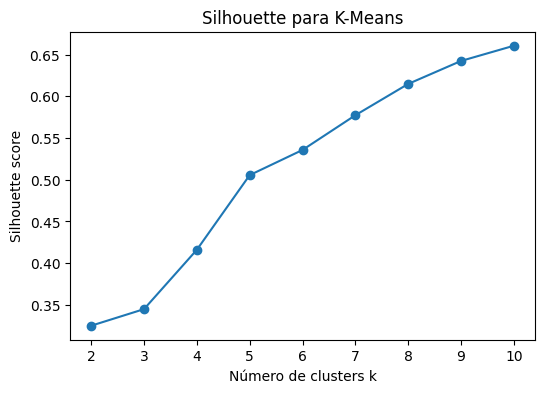

In [55]:
# Silhouette para K-Means
sil = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled, labels))
plt.figure(figsize=(6,4))
plt.plot(K, sil, 'o-')
plt.xlabel('Número de clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette para K-Means')
plt.show()

- A medida que aumenta k, el Silhouette score también mejora, lo que indica que los grupos están más separados y cohesionados.

- Sin embargo, el incremento se va suavizando, por lo que aunque el valor máximo está en 𝑘=10, valores como k=4 o k=5 ya ofrecen una buena segmentación con menos complejidad.



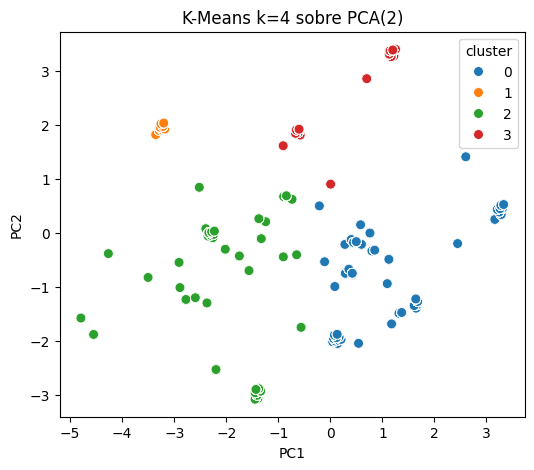

In [56]:
# K-Means final 
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters_km = kmeans.fit_predict(X_scaled)
df['cluster_kmeans'] = clusters_km

# Visualizamos en PCA
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_km, palette='tab10', s=50)
plt.title(f'K-Means k={k_opt} sobre PCA(2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='cluster')
plt.show()


- Se identifican 4 grupos diferenciados, aunque con algo de solapamiento.
- El método ha logrado separar varios conjuntos bien definidos (como los grupos naranja y rojo), mientras que otros (como el verde) están más dispersos.

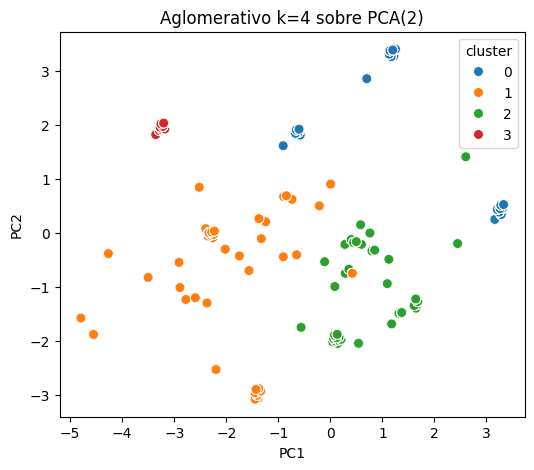

In [57]:
# Aplicar AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=k_opt, linkage='ward')
clusters_agg = agg.fit_predict(X_scaled)
df['cluster_agglo'] = clusters_agg

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_agg, palette='tab10', s=50)
plt.title('Aglomerativo k=4 sobre PCA(2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='cluster')
plt.show()


- El algoritmo ha agrupado los pacientes en 4 clústeres.
- Algunos grupos (como el rojo y el azul) aparecen más compactos y definidos, mientras que otros (como el naranja) están más dispersos, lo que indica mayor variabilidad interna.
- Se puede identificar patrones de comportamiento o salud comunes dentro de cada segmento.

In [58]:
# Perfilado de clusters (centroides y medias)
print("Centroides K-Means (en escala original):")
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
print(pd.DataFrame(centroids, columns=num_df.columns))

print("\nMedia de variables por cluster:")
print(df.groupby('cluster_kmeans')[num_df.columns].mean())


Centroides K-Means (en escala original):
         Gender        Age  Occupation  Sleep Duration  Quality of Sleep  \
0  4.876174e-01  41.274125    2.126388        7.698634          8.164816   
1  1.221245e-15  49.638889    5.000000        6.074074          6.000000   
2  7.869718e-01  37.700704    4.674296        6.379049          5.994718   
3  5.315615e-02  53.102990    6.448505        7.589701          8.335548   

   Physical Activity Level  Stress Level  BMI Category  Blood Pressure  \
0                59.056362      4.273271      0.099915        8.040137   
1                90.000000      8.000000      3.000000       23.000000   
2                41.038732      7.080986      1.929577       13.413732   
3                65.265781      3.425249      2.946844       21.897010   

   Heart Rate   Daily Steps  
0   67.701110   6807.856533  
1   75.000000  10000.000000  
2   74.063380   5494.190141  
3   68.172757   6386.046512  

Media de variables por cluster:
                  Gender

#### Resumen de Clusters (k=4)

### Cluster 0  
- **Edad**: ~41 años  
- **Género**: ligero sesgo femenino  
- **Sueño**: largo (7.7 h), buena calidad (8.2)  
- **Actividad**: moderada (59), bajo estrés (4.3)  
- **Salud**: IMC muy bajo, presión arterial baja, ritmo cardíaco medio, ≈6 800 pasos/día  

### Cluster 1  
- **Edad**: ~49 años  
- **Género**: solo hombres  
- **Sueño**: corto (6.1 h), baja calidad (6.0)  
- **Actividad**: muy alta (90), alto estrés (8.0)  
- **Salud**: IMC alto, presión arterial elevada, ritmo cardíaco alto, ≈10 000 pasos/día  

### Cluster 2  
- **Edad**: ~37 años  
- **Género**: mayoría mujeres  
- **Sueño**: moderado (6.4 h), baja calidad (6.0)  
- **Actividad**: baja (41), estrés medio-alto (7.1)  
- **Salud**: IMC medio, presión arterial media, ritmo cardíaco alto, ≈5 500 pasos/día  

### Cluster 3  
- **Edad**: ~53 años  
- **Género**: casi todos hombres  
- **Sueño**: largo (7.6 h), muy buena calidad (8.3)  
- **Actividad**: media-alta (65), muy bajo estrés (3.4)  
- **Salud**: IMC alto, presión arterial elevada, ritmo cardíaco medio, ≈6 400 pasos/día  

- ***Cluster 0 reúne a quienes descansan bien y tienen estilo de vida saludable (bajo BMI, estrés moderado).***
- ***Cluster 1 son mujeres muy activas pero con niveles de estrés y BMI altos y un sueño más corto.***
- ***Cluster 2 agrupa sobre todo hombres jóvenes con sueño justo, actividad baja y algo de estrés.***
- ***Cluster 3 engloba a personas mayores (casi todas mujeres) con muy buena calidad y duración de sueño, aunque con BMI y presión algo elevados.***

In [59]:


# datos
df = pd.read_csv('../data/combined_sleep_dataset.csv')
num_df = df.select_dtypes(include=['int64','float64']) \
           .drop(columns=['Sleep_disorder','Diagnosis_Confirmed'])

# Pipeline
pipe_clust = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',    PCA(n_components=2, random_state=42)),   # opcional: mantener para reproducir gráficos
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])


pipe_clust.fit(num_df)

# Guardar con pickle
with open('sleep_patient_segmentation.pkl', 'wb') as f:
    pickle.dump(pipe_clust, f)

print("Pipeline de clustering guardado en sleep_patient_segmentation.pkl")



Pipeline de clustering guardado en sleep_patient_segmentation.pkl
